In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from importer_snippets import biologic_mpt_voltammetry
from LinReg import PolyReg
from scipy import interpolate
import os
plt.style.use("JGW-PPT")

plt.rcParams["figure.figsize"] = (8,6)

In [3]:
dir_name = r"C:\Users\jgage\OneDrive - Stanford\Jaramillo Group\EC-data\GC-Variance-2mm_JGW2-09-17"
technique = 'CVA'

data_frames = {}
for file in os.listdir(dir_name):
    if file.endswith(".mpt"):
        if technique in str(file):
            path = os.path.join(dir_name, file)
            df = biologic_mpt_voltammetry(path)
            data_frames[file] = df
            # print(str(file)[:-4] + '.csv')
            # df.to_csv(str(path)[:-4] + '.csv')
            print(file)

1000rpm_JGW2-09-20_04_CVA_C02.mpt
1200rpm_JGW2-09-19_04_CVA_C02.mpt
1400rpm_JGW2-09-18_04_CVA_C02.mpt
1600rpm_JGW2-09-17_04_CVA_C02.mpt
400rpm_JGW2-09-22_04_CVA_C02.mpt
800rpm_JGW2-09-21_04_CVA_C02.mpt


In [5]:
a= ['400rpm_JGW2-09-22_04_CVA_C02.mpt', '800rpm_JGW2-09-21_04_CVA_C02.mpt', '1000rpm_JGW2-09-20_04_CVA_C02.mpt',
    '1200rpm_JGW2-09-19_04_CVA_C02.mpt', '1400rpm_JGW2-09-18_04_CVA_C02.mpt', '1600rpm_JGW2-09-17_04_CVA_C02.mpt']
rpm_series = []
for i in a:
    rpm_series.append(data_frames[i])

In [6]:
for i in range(len(rpm_series)):
    # Separate forward and reverse scans
    scan_direction_bools = []
    for k in range(len(rpm_series[i]['Ewe/V'])):
        if k == 0:
            scan_direction_bools.append(True)
        elif rpm_series[i]['Ewe/V'][k - 1]  < rpm_series[i]['Ewe/V'][k]:
            scan_direction_bools.append(True)
        else:
            scan_direction_bools.append(False)

    rpm_series[i]['forward'] = scan_direction_bools

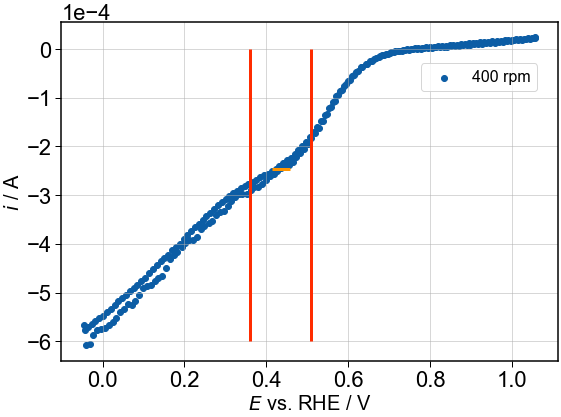

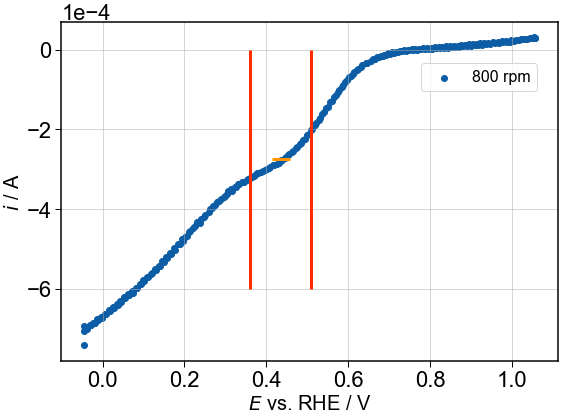

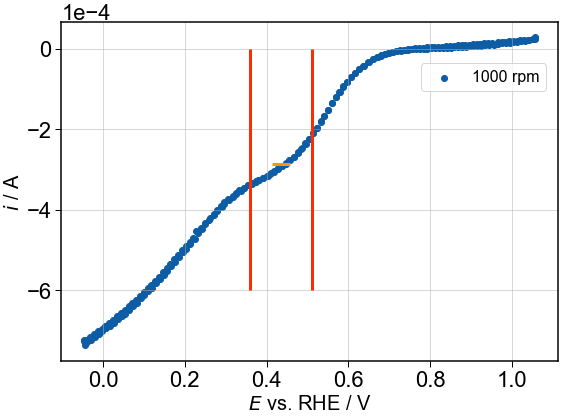

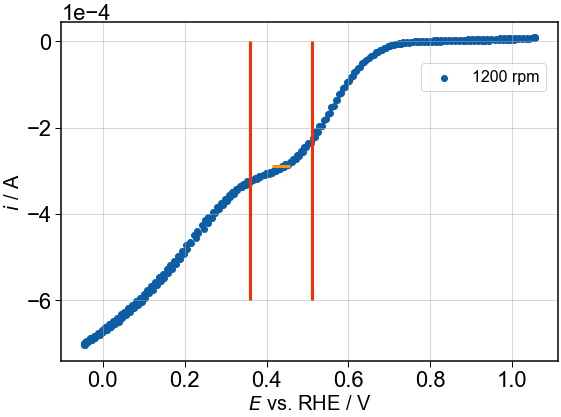

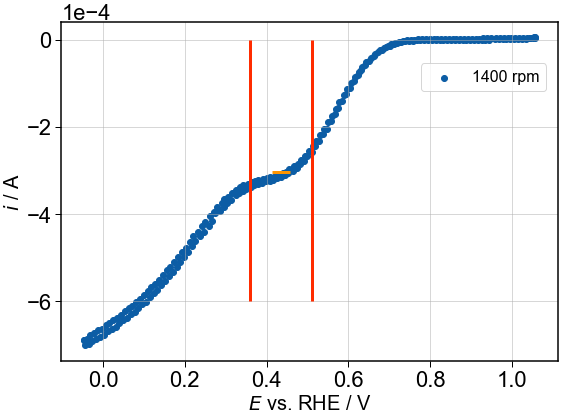

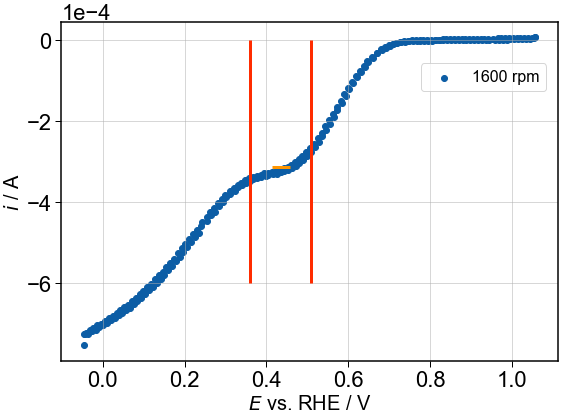

In [7]:
labels = ['400 rpm', '800 rpm', '1000 rpm', '1200 rpm', '1400 rpm', '1600 rpm']
selected_cycle = 3
ilc_est = []

for i in range(len(rpm_series)):
    fig, ax = plt.subplots()

    # Convert to RHE, current in Amps
    rpm_series[i]['E vs RHE'] = rpm_series[i]['Ewe/V'] + 0.958
    rpm_series[i]['<I>/A'] = rpm_series[i]['<I>/mA'] / 1000

    # Filter for cycle number
    x = rpm_series[i].loc[rpm_series[i]['cycle number'] == selected_cycle]['E vs RHE']
    y = rpm_series[i].loc[rpm_series[i]['cycle number'] == selected_cycle]['<I>/A']

    ax.scatter(x, y, label = labels[i], c='C00')

    # Check the middle region
    plt.vlines([.36, .51], -6.0e-4, 0, colors='C01')
    ilc_est.append(rpm_series[i].loc[rpm_series[i]['E vs RHE'].between(.36, .51)]['<I>/A'].mean())
    plt.scatter((.51+.36)/2, ilc_est[i], c='C03', marker='_', s=300)



    # ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.set_xlabel('$E$ vs. RHE / V')
    ax.set_ylabel('$i$ / A')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig.legend(loc=(0.75, 0.78))
    fig.tight_layout()
    plt.show()

coef_deg1      -9.949360e-06
std_err_deg1    6.719192e-07
coef_deg0      -1.825957e-04
std_err_deg0    7.101428e-06
r_squared       9.820835e-01
s_y             3.494318e-06
dtype: float64


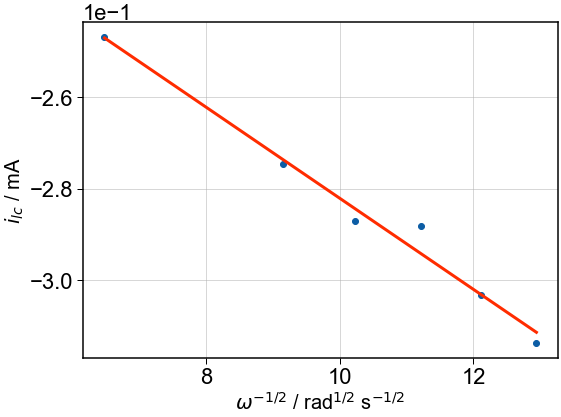

coef_deg1      -9.949360e-06
std_err_deg1    6.719192e-07
coef_deg0      -1.825957e-04
std_err_deg0    7.101428e-06
r_squared       9.820835e-01
s_y             3.494318e-06
dtype: float64

In [8]:
omega = np.array([400, 800, 1000, 1200, 1400, 1600])

x = (omega*2*np.pi / 60)**(1/2) # Convert to rad/s, then sqrt
y = np.array(ilc_est)

fit = PolyReg(x, y, 1)
print(fit.report())

fig, ax = plt.subplots()

ax.scatter(x, y * 1000, label='Data') # Plot in mA, fit in A
ax.plot(x, fit.eval(x) * 1000, label='Fit', color='C01') # Plot in mA, fit in A
ax.set_xlabel('$\omega^{-1/2}$ / rad$^{1/2}$ s$^{-1/2}$')
ax.set_ylabel('$i_{lc}$ / mA')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# fig.legend(loc=(0.75, 0.78))
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(dir_name, 'ilc-omega0.5.png'))

fit.report()

In [9]:
df = pd.DataFrame({'omega':(omega*2*np.pi / 60), 'ilc': ilc_est})
df['omega0.5'] = np.sqrt(df['omega'])
df.to_excel(os.path.join(dir_name,'omega-series_GC-Variance-2mm_JGW2-09-17.xlsx'))